## Utils

In [1]:
import json

# File I/O utilities
def load_jsonl_to_list(jsonl_file_path):
    data_list = []
    with open(jsonl_file_path, 'r') as file:
        for line in file:
            json_obj = json.loads(line)
            data_list.append(json_obj)
    return data_list

# Load dataset
def load_dataset_from_file(filename):
    #if the file is json
    if filename.endswith('.json'):
        with open(filename, 'r') as file:
            return json.load(file)
    elif filename.endswith('.jsonl'):
        return load_jsonl_to_list(filename)
    else:
        raise ValueError("Invalid file format. Please provide a .json or .jsonl file.")

# Save dataset
def save_dataset(data, filename, convert_to_jsonl=False):
    if convert_to_jsonl:
        with open(filename, 'w') as file:
            for obj in data:
                file.write(json.dumps(obj) + '\n')
    else:
        with open(filename, 'w') as file:
            json.dump(data, file, indent=2)

In [32]:
import pandas as pd
from matplotlib import pyplot as plt

# Frequency table
def get_freq_table(df,column):
    return df[column].value_counts()
    
# Bar Plot & 
def bar_plot(ft, _xlabel, _ylabel):
    plt.rcParams["figure.figsize"] = [7, 3.50]
    plt.rcParams["figure.autolayout"] = True
    font = {'family' : 'DejaVu Sans',
            # 'weight' : 'bold',
            'size'   : 8}

    plt.rc('font', **font)

    fig, ax = plt.subplots()
    ax.set_xlabel('x-axis', fontsize = 8) 
    ax.set_ylabel('y-axis', fontsize = 8) 

    ft.plot(ax=ax, kind='bar', xlabel=_xlabel, ylabel=_ylabel)
    return plt

# Examples
# https://www.geeksforgeeks.org/plot-a-pie-chart-in-python-using-matplotlib/
# https://www.nxn.se/valent/making-nicer-looking-pie-charts-with-matplotlib


## Data

In [63]:
import os

dir = "/path/to/data/dir/"
my_cache_dir = "/path/to/hf/chache/dir/"

In [2]:
# Original data
from datasets import load_dataset
import os

dataset_path = os.path.join(dir,"1_openplatypus.jsonl")
dataset = load_dataset("json", data_files=dataset_path,  num_proc=os.cpu_count(), cache_dir=my_cache_dir)

print(dataset)
print(dataset["train"].features)
print(dataset["train"][0])
samples_original = len(dataset["train"])
print(f"# of samples in original dataset: {samples_original}")

DatasetDict({
    train: Dataset({
        features: ['uuid', 'input', 'output', 'conversations', 'phase2_data', 'source', 'domain', 'language_source', 'input_length', 'output_length', 'number_turns', 'metadata'],
        num_rows: 14577
    })
})
{'uuid': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'conversations': [{'from': Value(dtype='string', id=None), 'value': Value(dtype='string', id=None)}], 'phase2_data': Value(dtype='string', id=None), 'source': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'language_source': Value(dtype='string', id=None), 'input_length': Value(dtype='int64', id=None), 'output_length': Value(dtype='int64', id=None), 'number_turns': Value(dtype='int64', id=None), 'metadata': {'gen_input_configs': {'input_generator': Value(dtype='null', id=None)}}}
{'uuid': '2ec741bb-bc26-4470-b2e0-caa54e6c4110', 'input': 'A board game spinner is divided into three parts labeled 

In [3]:
# Labeled data
from datasets import load_dataset
import os

dataset_path = os.path.join(dir,"1_openplatypus_difficulty_quality_category_language_sample-quality_fi_distance.jsonl")
dataset = load_dataset("json", data_files=dataset_path, num_proc=os.cpu_count(), cache_dir=my_cache_dir)

print(dataset)
print(dataset["train"].features)
print(dataset["train"][0])
samples_labeled = len(dataset["train"])
print(f"# of samples in original dataset: {samples_labeled}")

DatasetDict({
    train: Dataset({
        features: ['uuid', 'input', 'output', 'conversations', 'phase2_data', 'source', 'domain', 'language_source', 'input_length', 'output_length', 'number_turns', 'metadata', 'intent', 'knowledge', 'difficulty', 'input_quality', 'input_quality_explanation', 'task_category', 'language_identify', 'judge_quality_score', 'judge_quality_explanation', 'min_neighbor_distance', 'repeat_count', 'min_similar_uuid'],
        num_rows: 14577
    })
})
{'uuid': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'conversations': [{'from': Value(dtype='string', id=None), 'value': Value(dtype='string', id=None)}], 'phase2_data': Value(dtype='string', id=None), 'source': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'language_source': Value(dtype='string', id=None), 'input_length': Value(dtype='int64', id=None), 'output_length': Value(dtype='int64', id=None), 'number_turns':

## Data Analysis

#### Filtering
- Filter out invalid samples
- What do we consider invalid?
    - Null or empty samples (instructions or responses)
    - Null values in labels


In [15]:
def filter_out_invalid_samples(example): 
    return (
        # Validate input and output
        example['input'] is not None
        and example['output'] is not None
        and len(example['input']) > 0
        and len(example['output']) > 0
        # and not example['input'].endswith(':') # Magpai applies this filer, but why?
        # Remove instances with null tags
        and example['input_quality'] is not None
        and example['judge_quality_score'] is not None
        and example['difficulty'] is not None
        and example['task_category'] is not None
    )

filtered_invalids = dataset['train'].filter(filter_out_invalid_samples)
print(f"# of samples after applying filter: {len(filtered_invalids)}")

# of samples after applying filter: 13050


In [16]:
# unpack labels assigned by one model ( mistralai/Mistral-7B-Instruct-v0.3) for simplicity
def unpack_scores(example):
    example["input_quality"] = example['input_quality'][0]['mistralai/Mistral-7B-Instruct-v0.3']
    example["difficulty"] = example['difficulty'][0]['mistralai/Mistral-7B-Instruct-v0.3']
    example["judge_quality_score"] = example['judge_quality_score'][0]['mistralai/Mistral-7B-Instruct-v0.3']
    example["task_category"] = example['task_category'][0]['mistralai/Mistral-7B-Instruct-v0.3']
    return example

ds_unpacked = filtered_invalids.map(unpack_scores)
print(ds_unpacked)

Dataset({
    features: ['uuid', 'input', 'output', 'conversations', 'phase2_data', 'source', 'domain', 'language_source', 'input_length', 'output_length', 'number_turns', 'metadata', 'intent', 'knowledge', 'difficulty', 'input_quality', 'input_quality_explanation', 'task_category', 'language_identify', 'judge_quality_score', 'judge_quality_explanation', 'min_neighbor_distance', 'repeat_count', 'min_similar_uuid'],
    num_rows: 13050
})


#### Filter out samples with tags with invalid format
- Examples of invalid tags for 'judge_quality_score': '5' '4' '[4,5,5]' '[4]' '[5,5,5]' '[5]' '2' '[4,5]' '0' '3' '1'

In [21]:
def validate_scores_format(example):
    return (
        example["input_quality"] in ['very poor','poor','average','good','excellent']
        and example["difficulty"] in ['very easy','easy','medium','hard','very hard']
        and example["judge_quality_score"] in ['1','2','3','4','5']
        and len(example["task_category"]) > 0
        # and not example['input'].endswith(':') # check if it has effect with magpie data
        # and example['instruct_reward'] > -10
    )
ds_valid_format = ds_unpacked.filter(validate_scores_format)
print(ds_valid_format)

Filter:   0%|          | 0/13050 [00:00<?, ? examples/s]

Dataset({
    features: ['uuid', 'input', 'output', 'conversations', 'phase2_data', 'source', 'domain', 'language_source', 'input_length', 'output_length', 'number_turns', 'metadata', 'intent', 'knowledge', 'difficulty', 'input_quality', 'input_quality_explanation', 'task_category', 'language_identify', 'judge_quality_score', 'judge_quality_explanation', 'min_neighbor_distance', 'repeat_count', 'min_similar_uuid'],
    num_rows: 12858
})


In [22]:
# Pandas conversion
df = ds_valid_format.to_pandas()
df.loc[:,['uuid','input', 'output', 'input_quality', 'difficulty', 'judge_quality_score', 'task_category']].head()

,uuid,input,output,input_quality,difficulty,judge_quality_score,task_category
0,2ec741bb-bc26-4470-b2e0-caa54e6c4110,A board game spinner is divided into three par...,To find the probability of the spinner landing...,excellent,easy,5,Math
1,342182ae-4a7d-4c54-8aa7-99c00467a7f5,My school's math club has 6 boys and 8 girls. ...,"I need to choose 6 people out of 14, and the o...",good,easy,5,Math
2,f027f177-6eb0-472c-93c5-4df3f04a1842,How many 4-letter words with at least one cons...,First we count the number of all 4-letter word...,excellent,easy,5,Reasoning
3,f0496a98-8cc6-4a12-876d-011276c1d5f2,Melinda will roll two standard six-sided dice ...,She can do this if and only if at least one of...,excellent,easy,5,Math
4,8f6f0e72-701d-4d62-ab93-e2dc927ce0f0,"Let $p$ be the probability that, in the proces...",Think of the problem as a sequence of H's and ...,excellent,medium,5,Math


##### Task Categories

In [38]:
# Get unique values from column 'task' (from magpie)
llm_categories = df['task_category'].unique()

# Print output
print(f"categories: {llm_categories}")


categories: ['Math' 'Reasoning' 'Data analysis' 'Information seeking'
 'Coding & Debugging' 'Editing' 'Advice seeking' 'Role playing'
 'Legal Advice seeking' 'Law' 'Planning']


task_category
Math                    11856
Reasoning                 550
Coding & Debugging        196
Data analysis             129
Information seeking        67
Advice seeking             45
Editing                     6
Role playing                5
Law                         2
Legal Advice seeking        1
Planning                    1
Name: count, dtype: int64


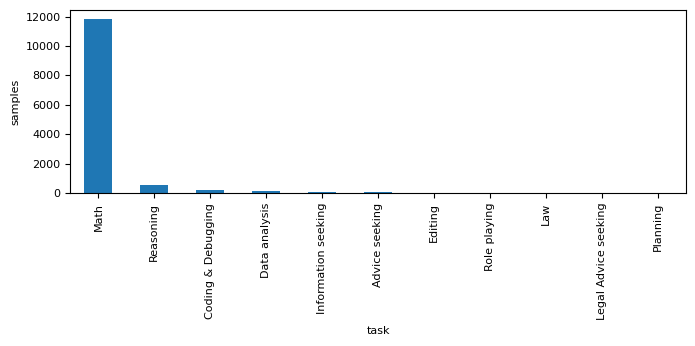

In [34]:
import pandas as pd
from matplotlib import pyplot as plt

ft = get_freq_table(df,'task_category')
print(ft)

plt = bar_plot(ft, 'task', 'samples')
plt.show()

##### Input Quality & Sample Quality

In [37]:
# Get unique values from column 'task' (from magpie)
llm_qual = df['input_quality'].unique()

llm_qual_sample = df['judge_quality_score'].unique()

# Print output
print(f"Input Quality labels: {llm_qual}")
print(f"Sample quality scores: {llm_qual_sample}")

Input Quality labels: ['excellent' 'good' 'average' 'poor' 'very poor']
Sample quality scores: ['5' '4' '2' '3' '1']


input_quality
good         6369
excellent    4863
average      1578
poor           43
very poor       5
Name: count, dtype: int64


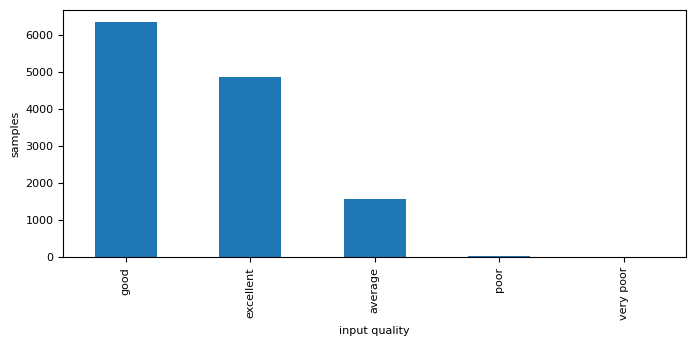

In [41]:
import pandas as pd
from matplotlib import pyplot as plt

ft = get_freq_table(df,'input_quality')
print(ft)

plt = bar_plot(ft, 'input quality', 'samples')
plt.show()

Observations:
- These results are relevant for data quality filtering.
- What input quality should we take for filtering? Option A: 'good' and 'excellent', Option B: 'excellent'

Magpie Reference:
- "First, both datasets are of high quality, with the majority of instances rated ‘average’ or higher. In addition, the overall quality of MAGPIE-Pro surpasses that of MAGPIE-Air."

judge_quality_score
5    10802
4     1868
1      122
3       62
2        4
Name: count, dtype: int64


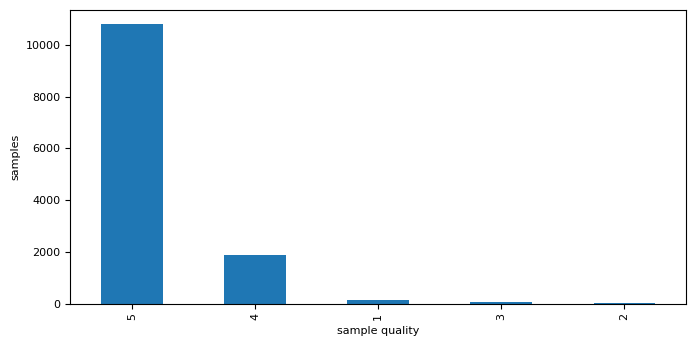

In [42]:
import pandas as pd
from matplotlib import pyplot as plt

ft = get_freq_table(df,'judge_quality_score')
print(ft)

plt = bar_plot(ft, 'sample quality', 'samples')
plt.show()

Observations:
- These results are relevant for data quality filtering.
- Most instances were labeled with a score of 5.
- What sample quality should we take for filtering?

Magpie Reference:
- They did not label sample quality by using LLM as a judge, for responses they used the reward model difference.

##### Input Difficulty

In [39]:
llm_qual = df['difficulty'].unique()
# Print output
print(f"Dificulty labels: {llm_qual}")

Dificulty labels: ['easy' 'medium' 'very easy' 'hard' 'very hard']


difficulty
easy         6520
medium       5645
very easy     605
hard           85
very hard       3
Name: count, dtype: int64


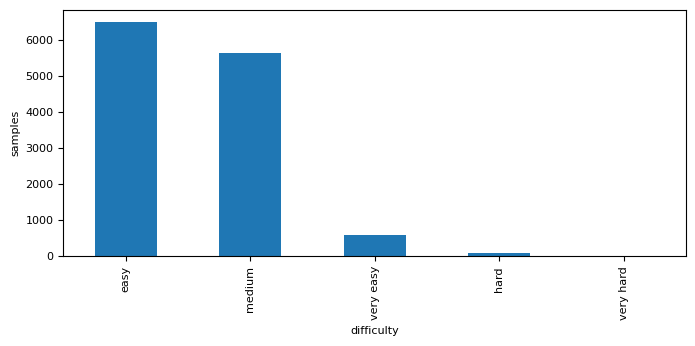

In [40]:
import pandas as pd
from matplotlib import pyplot as plt

ft = get_freq_table(df,'difficulty')
print(ft)

plt = bar_plot(ft, 'difficulty', 'samples')
plt.show()

Observations:
- Majority of instances are rated as easy or medium
- Note: Magpie's quality filtering function, is not using 'difficulty' as metric.

Magpie Reference:
- "We observe that the distributions across difficulty levels are similar for MAGPIE-Air and MAGPIE-Pro. Most instances' difficulty is easy or medium."



#### Instruction Similarity

In [44]:
df.loc[:,['min_neighbor_distance','repeat_count','min_similar_uuid']].head()

,min_neighbor_distance,repeat_count,min_similar_uuid
0,0.231522,0,None
1,0.130077,0,None
2,0.174045,0,None
3,0.368189,0,None
4,0.547976,0,None


<Axes: ylabel='Frequency'>

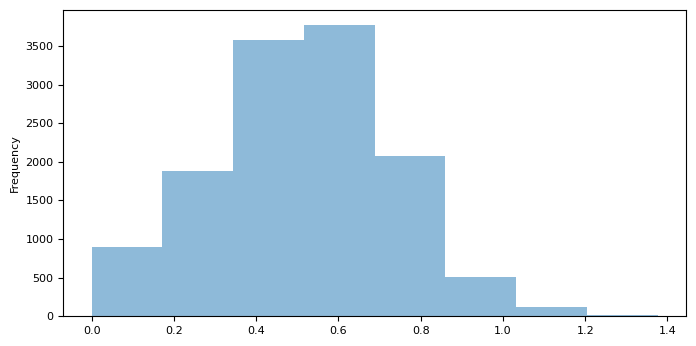

In [49]:
import pandas as pd
from matplotlib import pyplot as plt

# ft = get_freq_table(df,'min_neighbor_distance')
# print(ft)

# plt = bar_plot(ft, 'min neighbor distance', 'samples')
# plt.show()

df['min_neighbor_distance'].plot.hist(bins=8, alpha=0.5)

Important for quality filtering:
- Magpie's removal of repetitions (phase II) process keeps track of duplicates at the instance level.
- If an instance has duplicates
    - the 'uuid' value that identifies the instance is copied to its own 'min_similar_uuid' key
    - the 'uuid' value that identifies the instance is assigned to the 'min_similar_uuid' of its duplicates
- The 'min_neighbor_distance' is what defines if an instance should be labeled as having duplicates or as a duplicate. 
- Instances with zero duplicates have a 'None' value in 'min_similar_uuid'

Example

Instance A
```
"uuid": "c2b50dd9-5f3a-4c29-aabc-fe41ff9ab2a9"
"min_similar_uuid": "c2b50dd9-5f3a-4c29-aabc-fe41ff9ab2a9"
```

Instance B (duplicate of A)
```
"uuid": "d1a1f53d-0687-4880-8d87-8ee7be63809f"
"min_similar_uuid": "c2b50dd9-5f3a-4c29-aabc-fe41ff9ab2a9"
```
Instance C (duplicate of A)
```
"uuid": "5f269e5e-9bd7-4c7a-8e89-c7499eb3a2e6"
"min_similar_uuid": "c2b50dd9-5f3a-4c29-aabc-fe41ff9ab2a9"
```

Quality filter should keep instances with:

```
example['min_similar_uuid'] is None
or example['uuid'] == example['min_similar_uuid']
```



#### High Quality Filtering Example

This example is very close to magpie's notebook

A quality filter must be applied to each dataset, the filter values might be different per dataset.

- input_quality: take samples labeled as 'good' and 'excellent'
- judge_quality_score: take samples labeled with highest score: '5' 
- Repetition: removed samples with repeated inputs

This filter is not considering 'difficulty' or length (input, output).

In [50]:
print(ds_valid_format)

Dataset({
    features: ['uuid', 'input', 'output', 'conversations', 'phase2_data', 'source', 'domain', 'language_source', 'input_length', 'output_length', 'number_turns', 'metadata', 'intent', 'knowledge', 'difficulty', 'input_quality', 'input_quality_explanation', 'task_category', 'language_identify', 'judge_quality_score', 'judge_quality_explanation', 'min_neighbor_distance', 'repeat_count', 'min_similar_uuid'],
    num_rows: 12858
})


In [56]:
def high_quality_filter(example):
    return (
        example['input_quality'] in ['good', 'excellent']
        and example['judge_quality_score'] in ['5']
        # and example['instruct_reward'] > -10
        and (
            example['min_similar_uuid'] is None
            or example['uuid'] == example['min_similar_uuid'] 
        )
    )
filtered_dataset = ds_valid_format.filter(high_quality_filter)
print(filtered_dataset)



Dataset({
    features: ['uuid', 'input', 'output', 'conversations', 'phase2_data', 'source', 'domain', 'language_source', 'input_length', 'output_length', 'number_turns', 'metadata', 'intent', 'knowledge', 'difficulty', 'input_quality', 'input_quality_explanation', 'task_category', 'language_identify', 'judge_quality_score', 'judge_quality_explanation', 'min_neighbor_distance', 'repeat_count', 'min_similar_uuid'],
    num_rows: 9464
})
